C:\Users\aswin\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\aswin\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


trial 0


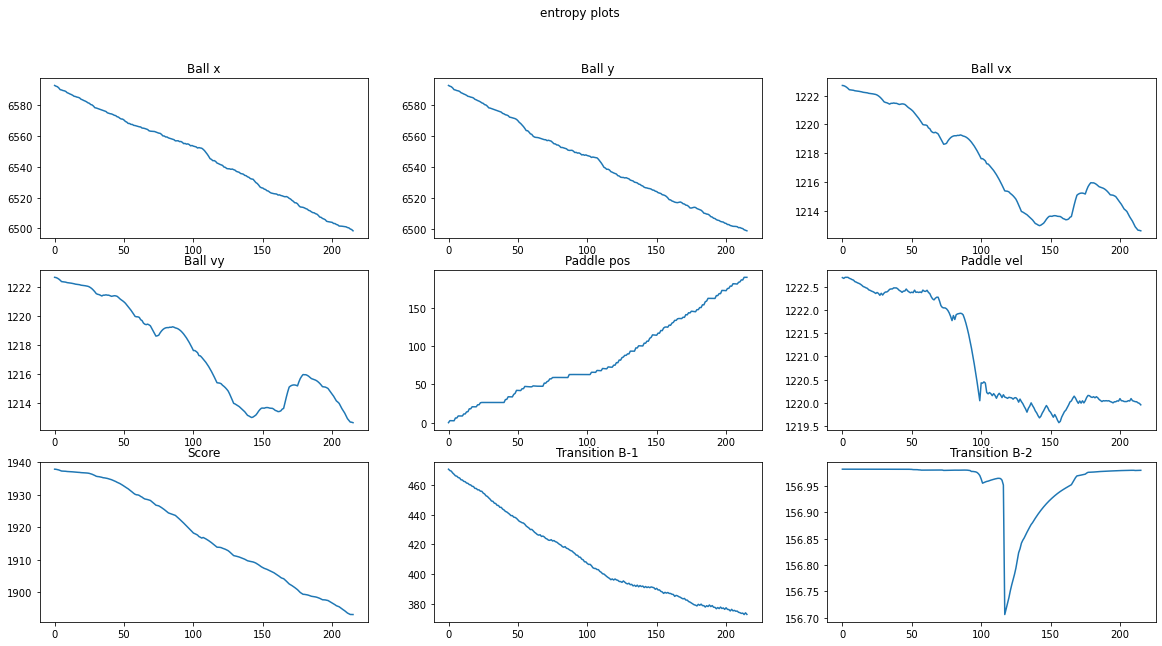

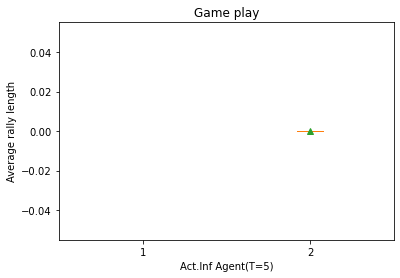

In [1]:
from CustomPongEnv_v0_ram import Custom_Pong
import numpy as np
import random
from math_helper_functions import pong_state_to_obs, normalise_A, normalise_B
import pymdp
from pymdp import utils
import numpy as np
from scipy.stats import dirichlet
from pymdp.agent import Agent
from ai_agent_planner_riskonly import action_dist
from scipy.stats import entropy
from matplotlib import pyplot as plt

random.seed(10)
np.random.seed(10)

env = Custom_Pong()
states = env.observation_space.shape[0]
actions = env.action_space.n

# (Hidden)Factors
# Paddle (Hypothesis)
s1_size = 42
# Ball (Hypothesis)
s2_size = 42

num_states = [s1_size, s2_size]
num_factors = len(num_states)

# Rewards
reward_modes = 3 #Max score-5 (assumption)

# Controls
s1_actions = ['Stay', 'Play-Up', 'Play-Down']
s2_actions = ['Do nothing']

num_controls = [len(s1_actions), len(s2_actions)]

# Observations
#Ball-x
o1_obs_size = s1_size
#Ball-y
o2_obs_size = s1_size
#Ball-vx
o3_obs_size = 2
#Ball-vy
o4_obs_size = 2
#Paddle-pos
o5_obs_size = s1_size
#Paddle-velocity
o6_obs_size = 2
#Reward (Shock, Chocolate, and Nothing)
reward_obs_size = reward_modes

num_obs = [o1_obs_size, o2_obs_size, o3_obs_size, o4_obs_size, o5_obs_size, o6_obs_size, reward_obs_size]
num_modalities = len(num_obs)

EPS_VAL = 1e-16 # Negligibleconstant

# Likelhiood Dynamics
A = utils.random_A_matrix(num_obs, num_states)*0 + EPS_VAL

# Paddle position is initialised as fully observable
for i in range(num_states[1]):
    A[4][:,:,i] = np.eye(num_states[0]) + EPS_VAL

# Transisition dynamics
# Initialised as random becuase the agent need to learn the dynamics

B = utils.random_B_matrix(num_states, num_controls)*0 + EPS_VAL

numS = 1
for i in num_states:
    numS *= i
numA = 1
for i in num_controls:
    numA *= i

A = normalise_A(A, num_states, num_modalities)
B = normalise_B(B, num_states, num_controls)

# Prior preferences for biasing the generative model to control behaviour

# The preferences are set uniform for all the hidden-states except the reward function
C = utils.obj_array_uniform(num_obs)

# Highest for the high-score and lowest for the lowscore
C_score = np.array([-5.8, 0 , 1])
# Normalising the prior preference
C[6] = pymdp.maths.softmax(1*C_score)

D = utils.obj_array_uniform(num_states)

A_naive = A
B_naive = B

# %time Q_pi = action_dist(A, B, C, T=5, sm_par=1)
# %time qs = pymdp.inference.update_posterior_states(A, observation, prior = qs_prev)

# Dynamic programming active inference simulations

trials = 10
episodes = 400
planning_horizon = 3
T = planning_horizon
#Factor for resolution of obeservations
factor = 5

rally_length_raw = np.zeros((trials,episodes))
e = []

for trial in range(trials):
    print("trial", trial)
    
    EPS_VAL = 1e-16 #negligibleconstant
    # Likelhiood Dynamics
    A = A_naive

    # Transisition dynamics
    # Initialised as random becuase the agent need to learn the dynamics
    B = B_naive

    # Normalising A and B as probability distributions

    A = normalise_A(A, num_states, num_modalities)
    B = normalise_B(B, num_states, num_controls)

    # Prior preferences for biasing the generative model to control behaviour is unchanging
    
    #Prior over hidden-states before a fresh trial
    D = utils.obj_array_uniform(num_states)
    
    #Episodes inside a trial
    for episode in range(episodes):
        # print("episode", episode)

        state = env.reset()
        done = False
        score = 0

        t=0
        #Planning for the upcoming episode
        Q_pi = action_dist(A, B, C, T=planning_horizon, sm_par=1)
        
        while not done:
            # env.render()
            if(t==0):
                qs = D
                qs_prev = qs
   
            q_states_vec = np.kron(qs[0],qs[1])
            
            action = np.random.choice([0,1,2], size=None, replace=True, p=np.matmul(Q_pi[t],q_states_vec))
            state, reward, done, info = env.step(action)
            score += reward

            observation = pong_state_to_obs(state, reward, factor)

            qs = pymdp.inference.update_posterior_states(A, observation, prior = qs_prev)
            
            if(t == 0):
                qs0 = qs

            # Learning
            A = pymdp.learning.update_obs_likelihood_dirichlet(A, A, observation, qs, lr=1.0, modalities='all')

            actions = np.array([int(action),0])
            B = pymdp.learning.update_state_likelihood_dirichlet(B, B, actions, qs, qs_prev, lr=1.0, factors='all')

            e.append([np.sum(entropy(A[0])), np.sum(entropy(A[1])), np.sum(entropy(A[2])), np.sum(entropy(A[3])), np.sum(entropy(A[4])), np.sum(entropy(A[5])), np.sum(entropy(A[6])), np.sum(entropy(B[0])) , np.sum(entropy(B[1]))])
            
            if(t == 0):
                D = pymdp.learning.update_state_prior_dirichlet(D, qs0, lr=1.0, factors='all')
                D[0] = pymdp.maths.softmax(D[0])
                D[1] = pymdp.maths.softmax(D[0])

            t += 1
            qs_prev = qs

            if(t == T-1):
                t = 0
                #Normalising A and B
                A = normalise_A(A, num_states, num_modalities)
                B = normalise_B(B, num_states, num_controls)

        rally_length_raw[trial][episode] = score+1

    env.close()

from matplotlib import pyplot as plt
x = np.array(e)
x.shape

fig, axs = plt.subplots(3,3,figsize=(20,10))
fig.suptitle('entropy plots')

axs[0,0].plot(x[:,0])
axs[0,0].title.set_text('Ball x')
axs[0,1].plot(x[:,1])
axs[0,1].title.set_text('Ball y')
axs[0,2].plot(x[:,2])
axs[0,2].title.set_text('Ball vx')
axs[1,0].plot(x[:,3])
axs[1,0].title.set_text('Ball vy')
axs[1,1].plot(x[:,4])
axs[1,1].title.set_text('Paddle pos')
axs[1,2].plot(x[:,5])
axs[1,2].title.set_text('Paddle vel')
axs[2,0].plot(x[:,6])
axs[2,0].title.set_text('Score')

axs[2,1].plot(x[:,7])
axs[2,1].title.set_text('Transition B-1')
axs[2,2].plot(x[:,8])
axs[2,2].title.set_text('Transition B-2')
plt.savefig('graph-5a.png', dpi=500, bbox_inches='tight')
plt.show()

rally_length_1_raw = rally_length_raw[:, 0:int(episodes/4)]
rally_length_2_raw = rally_length_raw[:, int(episodes/4):episodes]

rally_length_1 = np.mean(rally_length_1_raw, axis=0)
rally_length_2 = np.mean(rally_length_2_raw, axis=0)
x = [rally_length_1, rally_length_2]

#Plotting
xy = [x[0], x[1]]

plt.boxplot(xy, showmeans=True, positions=[1,2])
plt.ylabel("Average rally length")
plt.xlabel("Act.Inf Agent(T=3)")
plt.title("Game play")
plt.savefig('graph-5.png', dpi=500, bbox_inches='tight')